<a href="https://colab.research.google.com/github/RumeysaCeylan/ImageClassification/blob/main/vgg19_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model, load_model
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import cv2
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tqdm import tqdm


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm

import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb



from keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from keras.callbacks import EarlyStopping, ModelCheckpoint


In [2]:
from google.colab import drive
drive.mount('/content/drive')
     

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

valid_datagen = ImageDataGenerator(rescale = 1./255)


# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/archive/Dataset',
                                                 target_size = (224, 224),
                                                 batch_size = 128,
                                                 class_mode = 'categorical')



valid_set = valid_datagen.flow_from_directory(directory = '/content/drive/MyDrive/archive/validation',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 128)
     

test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/archive/Test',
                                            target_size = (224, 224),
                                            batch_size = 128,
                                            class_mode = 'categorical')

Found 4030 images belonging to 4 classes.
Found 1103 images belonging to 4 classes.
Found 1281 images belonging to 4 classes.


100%|██████████| 5/5 [02:05<00:00, 25.14s/it]


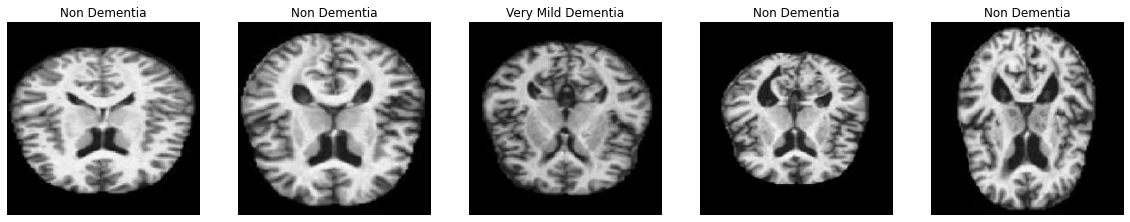

In [8]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(20,20))

for i in tqdm(range(0,5)):
    rand1 = np.random.randint(len(training_set))
    rand2 = np.random.randint(100)
    ax[i].imshow(training_set[rand1][0][rand2])
    ax[i].axis('off')
    a = training_set[rand1][1][rand2]
    if a[0] == 1:
        ax[i].set_title('Mild Dementia')
    elif a[1] == 1:
        ax[i].set_title('Moderate Dementia')
    elif a[2] == 1:
        ax[i].set_title('Non Dementia')
    elif a[3] == 1:
        ax[i].set_title('Very Mild Dementia')

In [9]:
IMAGE_SIZE = [224, 224]
vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

80134624/80134624 [==============================] - 0s 0us/step


In [10]:
for layer in vgg.layers:
  layer.trainable = False

In [13]:
folders=glob("/content/drive/MyDrive/archive/Dataset/*")
folders

['/content/drive/MyDrive/archive/Dataset/Non_Demented',
 '/content/drive/MyDrive/archive/Dataset/Very_Mild_Demented',
 '/content/drive/MyDrive/archive/Dataset/Mild_Demented',
 '/content/drive/MyDrive/archive/Dataset/Moderate_Demented']

In [14]:
x = Flatten()(vgg.output)

In [15]:
prediction = Dense(len(folders), activation='softmax')(x)
 
# creating a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [17]:
import tensorflow 

OPT    = tensorflow.keras.optimizers.Adam(lr=0.001)

model.compile(loss='categorical_crossentropy',
              metrics=[tensorflow.keras.metrics.AUC(name = 'auc')],
              optimizer=OPT)


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
filepath = './content/drive/MyDrive/Colab Notebooks/best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [19]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [20]:
from keras.preprocessing.image import ImageDataGenerator

In [21]:
# fiting the model
 
r = model.fit(
  training_set,
  validation_data=valid_set,
  epochs=50,
  callbacks = callback_list,
  steps_per_epoch=len(training_set),
  validation_steps=len(valid_set)
)


Epoch 1/50
32/32 [==============================] - ETA: 0s - loss: 1.4983 - accuracy: 0.4764 

32/32 [==============================] - 952s 29s/step - loss: 1.4983 - accuracy: 0.4764 - val_loss: 1.4342 - val_accuracy: 0.4062
Epoch 2/50
32/32 [==============================] - ETA: 0s - loss: 0.8828 - accuracy: 0.5921

32/32 [==============================] - 57s 2s/step - loss: 0.8828 - accuracy: 0.5921 - val_loss: 1.6123 - val_accuracy: 0.4062
Epoch 3/50
32/32 [==============================] - ETA: 0s - loss: 0.8296 - accuracy: 0.6166

32/32 [==============================] - 57s 2s/step - loss: 0.8296 - accuracy: 0.6166 - val_loss: 1.3418 - val_accuracy: 0.4125
Epoch 4/50
32/32 [==============================] - ETA: 0s - loss: 0.7285 - accuracy: 0.6720

32/32 [==============================] - 57s 2s/step - loss: 0.7285 - accuracy: 0.6720 - val_loss: 1.4718 - val_accuracy: 0.4071
Epoch 5/50
32/32 [==============================] - ETA: 0s - loss: 0.7013 - accuracy: 0.6906

32/32 [==============================] - 57s 2s/step - loss: 0.7013 - accuracy: 0.6906 - val_loss: 1.3580 - val_accuracy: 0.4170
Epoch 6/50
32/32 [==============================] - ETA: 0s - loss: 0.6846 - accuracy: 0.6955

32/32 [==============================] - 57s 2s/step - loss: 0.6846 - accuracy: 0.6955 - val_loss: 1.2921 - val_accuracy: 0.4370
Epoch 7/50
32/32 [==============================] - ETA: 0s - loss: 0.6705 - accuracy: 0.7035

32/32 [==============================] - 58s 2s/step - loss: 0.6705 - accuracy: 0.7035 - val_loss: 1.4694 - val_accuracy: 0.4170
Epoch 8/50
32/32 [==============================] - ETA: 0s - loss: 0.6549 - accuracy: 0.7099

32/32 [==============================] - 57s 2s/step - loss: 0.6549 - accuracy: 0.7099 - val_loss: 2.2145 - val_accuracy: 0.4071
Epoch 9/50
32/32 [==============================] - ETA: 0s - loss: 0.6764 - accuracy: 0.6990

32/32 [==============================] - 57s 2s/step - loss: 0.6764 - accuracy: 0.6990 - val_loss: 1.9216 - val_accuracy: 0.4143
Epoch 10/50
32/32 [==============================] - ETA: 0s - loss: 0.6055 - accuracy: 0.7412

32/32 [==============================] - 57s 2s/step - loss: 0.6055 - accuracy: 0.7412 - val_loss: 1.2508 - val_accuracy: 0.4651
Epoch 11/50
32/32 [==============================] - ETA: 0s - loss: 0.5783 - accuracy: 0.7543

32/32 [==============================] - 57s 2s/step - loss: 0.5783 - accuracy: 0.7543 - val_loss: 1.5906 - val_accuracy: 0.4234
Epoch 12/50
32/32 [==============================] - ETA: 0s - loss: 0.5613 - accuracy: 0.7682

32/32 [==============================] - 57s 2s/step - loss: 0.5613 - accuracy: 0.7682 - val_loss: 1.3791 - val_accuracy: 0.4506
Epoch 13/50
32/32 [==============================] - ETA: 0s - loss: 0.5651 - accuracy: 0.7653

32/32 [==============================] - 57s 2s/step - loss: 0.5651 - accuracy: 0.7653 - val_loss: 1.3675 - val_accuracy: 0.4560
Epoch 14/50
32/32 [==============================] - ETA: 0s - loss: 0.5379 - accuracy: 0.7792

32/32 [==============================] - 57s 2s/step - loss: 0.5379 - accuracy: 0.7792 - val_loss: 1.4646 - val_accuracy: 0.4551
Epoch 15/50
32/32 [==============================] - ETA: 0s - loss: 0.5751 - accuracy: 0.7479

32/32 [==============================] - 57s 2s/step - loss: 0.5751 - accuracy: 0.7479 - val_loss: 1.6581 - val_accuracy: 0.4406
Epoch 16/50
32/32 [==============================] - ETA: 0s - loss: 0.5324 - accuracy: 0.7754

32/32 [==============================] - 62s 2s/step - loss: 0.5324 - accuracy: 0.7754 - val_loss: 1.5547 - val_accuracy: 0.4334
Epoch 17/50
32/32 [==============================] - ETA: 0s - loss: 0.5020 - accuracy: 0.8079

32/32 [==============================] - 58s 2s/step - loss: 0.5020 - accuracy: 0.8079 - val_loss: 1.5320 - val_accuracy: 0.4424
Epoch 18/50
32/32 [==============================] - ETA: 0s - loss: 0.5202 - accuracy: 0.7764

32/32 [==============================] - 59s 2s/step - loss: 0.5202 - accuracy: 0.7764 - val_loss: 1.5258 - val_accuracy: 0.4524
Epoch 19/50
32/32 [==============================] - ETA: 0s - loss: 0.5149 - accuracy: 0.7873

32/32 [==============================] - 57s 2s/step - loss: 0.5149 - accuracy: 0.7873 - val_loss: 1.5621 - val_accuracy: 0.4488
Epoch 20/50
32/32 [==============================] - ETA: 0s - loss: 0.4973 - accuracy: 0.7960

32/32 [==============================] - 59s 2s/step - loss: 0.4973 - accuracy: 0.7960 - val_loss: 1.7079 - val_accuracy: 0.4442
Epoch 21/50
32/32 [==============================] - ETA: 0s - loss: 0.4905 - accuracy: 0.7958

32/32 [==============================] - 58s 2s/step - loss: 0.4905 - accuracy: 0.7958 - val_loss: 1.6857 - val_accuracy: 0.4461
Epoch 22/50
32/32 [==============================] - ETA: 0s - loss: 0.4707 - accuracy: 0.8062

32/32 [==============================] - 57s 2s/step - loss: 0.4707 - accuracy: 0.8062 - val_loss: 1.6978 - val_accuracy: 0.4442
Epoch 23/50
32/32 [==============================] - ETA: 0s - loss: 0.4576 - accuracy: 0.8199

32/32 [==============================] - 57s 2s/step - loss: 0.4576 - accuracy: 0.8199 - val_loss: 1.4075 - val_accuracy: 0.4760
Epoch 24/50
32/32 [==============================] - ETA: 0s - loss: 0.4534 - accuracy: 0.8144

32/32 [==============================] - 57s 2s/step - loss: 0.4534 - accuracy: 0.8144 - val_loss: 1.4567 - val_accuracy: 0.4787
Epoch 25/50
32/32 [==============================] - ETA: 0s - loss: 0.4676 - accuracy: 0.8030

32/32 [==============================] - 57s 2s/step - loss: 0.4676 - accuracy: 0.8030 - val_loss: 1.8230 - val_accuracy: 0.4433
Epoch 26/50
32/32 [==============================] - ETA: 0s - loss: 0.4519 - accuracy: 0.8141

32/32 [==============================] - 57s 2s/step - loss: 0.4519 - accuracy: 0.8141 - val_loss: 1.7325 - val_accuracy: 0.4470
Epoch 27/50
32/32 [==============================] - ETA: 0s - loss: 0.4314 - accuracy: 0.8295

32/32 [==============================] - 57s 2s/step - loss: 0.4314 - accuracy: 0.8295 - val_loss: 1.7816 - val_accuracy: 0.4506
Epoch 28/50
32/32 [==============================] - ETA: 0s - loss: 0.4426 - accuracy: 0.8256

32/32 [==============================] - 57s 2s/step - loss: 0.4426 - accuracy: 0.8256 - val_loss: 1.6712 - val_accuracy: 0.4642
Epoch 29/50
32/32 [==============================] - ETA: 0s - loss: 0.4332 - accuracy: 0.8246

32/32 [==============================] - 57s 2s/step - loss: 0.4332 - accuracy: 0.8246 - val_loss: 1.6723 - val_accuracy: 0.4506
Epoch 30/50
32/32 [==============================] - ETA: 0s - loss: 0.4043 - accuracy: 0.8407

32/32 [==============================] - 57s 2s/step - loss: 0.4043 - accuracy: 0.8407 - val_loss: 1.8169 - val_accuracy: 0.4451
Epoch 31/50
32/32 [==============================] - ETA: 0s - loss: 0.3965 - accuracy: 0.8476

32/32 [==============================] - 57s 2s/step - loss: 0.3965 - accuracy: 0.8476 - val_loss: 1.5500 - val_accuracy: 0.4733
Epoch 32/50
32/32 [==============================] - ETA: 0s - loss: 0.4001 - accuracy: 0.8531

32/32 [==============================] - 57s 2s/step - loss: 0.4001 - accuracy: 0.8531 - val_loss: 1.6684 - val_accuracy: 0.4705
Epoch 33/50
32/32 [==============================] - ETA: 0s - loss: 0.3877 - accuracy: 0.8538

32/32 [==============================] - 56s 2s/step - loss: 0.3877 - accuracy: 0.8538 - val_loss: 1.6281 - val_accuracy: 0.4751
Epoch 34/50
32/32 [==============================] - ETA: 0s - loss: 0.4344 - accuracy: 0.8226

32/32 [==============================] - 57s 2s/step - loss: 0.4344 - accuracy: 0.8226 - val_loss: 2.1505 - val_accuracy: 0.4306
Epoch 35/50
32/32 [==============================] - ETA: 0s - loss: 0.3965 - accuracy: 0.8496

32/32 [==============================] - 57s 2s/step - loss: 0.3965 - accuracy: 0.8496 - val_loss: 2.1688 - val_accuracy: 0.4352
Epoch 36/50
32/32 [==============================] - ETA: 0s - loss: 0.3745 - accuracy: 0.8596

32/32 [==============================] - 56s 2s/step - loss: 0.3745 - accuracy: 0.8596 - val_loss: 2.2175 - val_accuracy: 0.4316
Epoch 37/50
32/32 [==============================] - ETA: 0s - loss: 0.3887 - accuracy: 0.8459

32/32 [==============================] - 56s 2s/step - loss: 0.3887 - accuracy: 0.8459 - val_loss: 1.7171 - val_accuracy: 0.4678
Epoch 38/50
32/32 [==============================] - ETA: 0s - loss: 0.3603 - accuracy: 0.8707

32/32 [==============================] - 58s 2s/step - loss: 0.3603 - accuracy: 0.8707 - val_loss: 1.9213 - val_accuracy: 0.4461
Epoch 39/50
32/32 [==============================] - ETA: 0s - loss: 0.3556 - accuracy: 0.8732

32/32 [==============================] - 57s 2s/step - loss: 0.3556 - accuracy: 0.8732 - val_loss: 1.8329 - val_accuracy: 0.4560
Epoch 40/50
32/32 [==============================] - ETA: 0s - loss: 0.3681 - accuracy: 0.8633

32/32 [==============================] - 57s 2s/step - loss: 0.3681 - accuracy: 0.8633 - val_loss: 1.8122 - val_accuracy: 0.4705
Epoch 41/50
32/32 [==============================] - ETA: 0s - loss: 0.3807 - accuracy: 0.8514

32/32 [==============================] - 57s 2s/step - loss: 0.3807 - accuracy: 0.8514 - val_loss: 1.5622 - val_accuracy: 0.4986
Epoch 42/50
32/32 [==============================] - ETA: 0s - loss: 0.4054 - accuracy: 0.8345

32/32 [==============================] - 56s 2s/step - loss: 0.4054 - accuracy: 0.8345 - val_loss: 1.9030 - val_accuracy: 0.4560
Epoch 43/50
32/32 [==============================] - ETA: 0s - loss: 0.3422 - accuracy: 0.8829

32/32 [==============================] - 57s 2s/step - loss: 0.3422 - accuracy: 0.8829 - val_loss: 1.8220 - val_accuracy: 0.4578
Epoch 44/50
32/32 [==============================] - ETA: 0s - loss: 0.3338 - accuracy: 0.8839

32/32 [==============================] - 56s 2s/step - loss: 0.3338 - accuracy: 0.8839 - val_loss: 1.7610 - val_accuracy: 0.4687
Epoch 45/50
32/32 [==============================] - ETA: 0s - loss: 0.3410 - accuracy: 0.8767

32/32 [==============================] - 57s 2s/step - loss: 0.3410 - accuracy: 0.8767 - val_loss: 1.6778 - val_accuracy: 0.4850
Epoch 46/50
32/32 [==============================] - ETA: 0s - loss: 0.3421 - accuracy: 0.8734

32/32 [==============================] - 56s 2s/step - loss: 0.3421 - accuracy: 0.8734 - val_loss: 1.2288 - val_accuracy: 0.5549
Epoch 47/50
32/32 [==============================] - ETA: 0s - loss: 0.3790 - accuracy: 0.8464

32/32 [==============================] - 57s 2s/step - loss: 0.3790 - accuracy: 0.8464 - val_loss: 1.6166 - val_accuracy: 0.4896
Epoch 48/50
32/32 [==============================] - ETA: 0s - loss: 0.3741 - accuracy: 0.8484

32/32 [==============================] - 59s 2s/step - loss: 0.3741 - accuracy: 0.8484 - val_loss: 2.4803 - val_accuracy: 0.4343
Epoch 49/50
32/32 [==============================] - ETA: 0s - loss: 0.3283 - accuracy: 0.8747

32/32 [==============================] - 57s 2s/step - loss: 0.3283 - accuracy: 0.8747 - val_loss: 1.8817 - val_accuracy: 0.4705
Epoch 50/50
32/32 [==============================] - ETA: 0s - loss: 0.3290 - accuracy: 0.8777

32/32 [==============================] - 56s 2s/step - loss: 0.3290 - accuracy: 0.8777 - val_loss: 2.3296 - val_accuracy: 0.4388


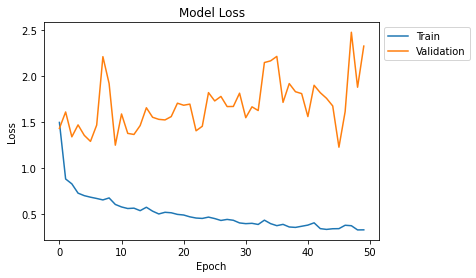

In [22]:

# Summarize history for loss

plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [ ]:

# Summarize history for loss

plt.plot(r.history['auc'])
plt.plot(r.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [24]:
model.evaluate(test_set)

11/11 [==============================] - 267s 27s/step - loss: 1.2259 - accuracy: 0.5925


[1.2259085178375244, 0.5925058722496033]

1/1 [==============================] - 0s 191ms/step
99.95 % chances are there that the image is Non_Demented


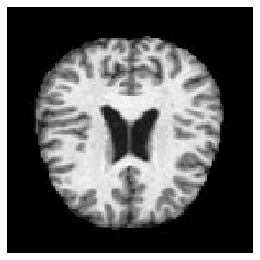

In [25]:

# Test Case 1: Non-Dementia

dic = test_set.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/drive/MyDrive/archive/Test/Non_Demented/non_105.jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
#answer = model.predict_classes(img)
answer = np.argmax(model.predict(img), axis=1)
#probability = round(np.max(model.predict_proba(img)*100),2)
probability=round(np.max(model.predict_on_batch(img)*100),2)
print(probability, '% chances are there that the image is',idc[answer[0]])

1/1 [==============================] - 0s 21ms/step
54.54 % chances are there that the image is Very_Mild_Demented


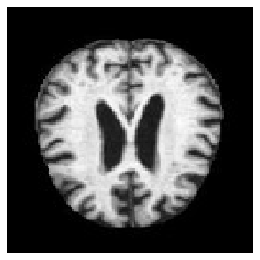

In [26]:
# Test Case 1: mild-Dementia

dic = test_set.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/drive/MyDrive/archive/Test/Mild_Demented/mild_113.jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
#answer = model.predict_classes(img)
answer = np.argmax(model.predict(img), axis=1)
#probability = round(np.max(model.predict_proba(img)*100),2)
probability=round(np.max(model.predict_on_batch(img)*100),2)
print(probability, '% chances are there that the image is',idc[answer[0]])